In [1]:
import matplotlib as mpl
import numpy as np
from data.box_utils import connect_3d_corners

def visualize_boxes_and_masks(pc, boxes, id_mask):
    vis_boxes = torch.cat((boxes, torch.zeros_like(boxes[:, :1], device=boxes.device)), dim=-1) # yaw angle
    box_pts = connect_3d_corners(vis_boxes.detach().cpu(), fill_points=50)
    cmap = plt.cm.jet  # define the colormap
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # force the first color entry to be grey
    cmaplist[0] = (.5, .5, .5, 1.0)
    
    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, cmap.N)
    
    # define the bins and normalize
    bounds = np.linspace(0, int(box_pts[:,-1].max()), int(box_pts[:,-1].max()) + 1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    plt.close()
    plt.scatter(pc[0, :, 0].detach().cpu(), pc[0, :, 1].detach().cpu(), c=id_mask.detach().cpu().numpy(), cmap=cmap, norm=norm, s=1)
    plt.scatter(box_pts[:,0], box_pts[:,1], c=box_pts[:,-1], cmap=cmap, norm=norm, s=1)
    
    return plt

def visualize_flow_and_instances(pc1, flow=None, mask=None):
    plt.close()
    cmap = plt.cm.jet  # define the colormap
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # force the first color entry to be grey
    cmaplist[0] = (.5, .5, .5, 1.0)
    
    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, cmap.N)
    
    # define the bins and normalize
    bounds = np.linspace(0, mask.shape[-1], mask.shape[-1] + 1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
    # video rovnou na serveru
    plt.figure(dpi=250)
    # plt.plot(pc1[:, 0], pc1[:, 1], 'bo', markersize=1, mew=0.01, mec='black', alpha=0.7)
    plt.scatter(pc1[:, 0], pc1[:, 1], c= mask.argmax(dim=-1), s=1, cmap=cmap, norm=norm, alpha=1)
    # plt.plot(pc1[:, 0] + gt_flow[:, 0], pc1[:, 1] + gt_flow[:, 1], 'g.', markersize=0.5, mew=1, alpha=1)
    if flow is not None:
        plt.quiver(pc1[:, 0], pc1[:, 1], flow[:, 0], flow[:, 1], color='green', alpha=1, scale=1, scale_units='xy')
    
    plt.axis('equal')
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    
    return plt
    
# visualize_flow_and_instances(pc1, gt_flow, mask)

# Prepare Data

In [2]:

from loss.flow import GeneralLoss
from tqdm import tqdm
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from vis.deprecated_vis import imshow, visualize_points3D, visualize_multiple_pcls
from data.dataloader import SFDataset4D
import torch
from pytorch3d.ops.knn import knn_points
from torch_scatter import scatter
from sklearn.cluster import DBSCAN
from pytorch3d.transforms import axis_angle_to_matrix

dataset = SFDataset4D(dataset_type='waymo', n_frames=7)
data = dataset[100]
device = torch.device('cuda:0')
pc1 = data['pc1'].to(device)
pc2 = data['pc2'].to(device)
gt_flow = data['gt_flow'].to(device)

# reduce radius for computation reasons
pc = pc1
max_radius = 10
for i in range(len(pc)):
    mask = torch.norm(pc[i], dim=-1) < max_radius   # blbe ne?
    gt_flow = gt_flow[:, mask]    
    pc = pc[:, mask]
    
pc = torch.stack([torch.cat((pc[i], i * torch.ones_like(pc[i][:, :1])), dim=-1) for i in range(len(pc))])

SmoothLosses = [GeneralLoss(pc1=pc[i:i+1, :, :3], pc2=pc[i:i+1, :, :3], K=16, smooth_weight=1) for i in range(len(pc1) - 1)]
# visualize_multiple_pcls(*[pc[i].detach().cpu().numpy() for i in range(len(pc))])

db_clusters = DBSCAN(eps=0.2, min_samples=5).fit_predict(pc[0].detach().cpu().numpy())
db_clusters = torch.tensor(db_clusters).to(device)

M = len(torch.unique(db_clusters))
logs_mask = torch.rand(pc.shape[0], pc.shape[1], M, device=device, requires_grad=True)

# Match Instances

In [6]:
optimizer = torch.optim.Adam([logs_mask], lr=0.01)



# todo box visuals, overlap, background without box
# [x] todo transform clusters to probability masks
# todo inter-sequence instance geometrical registration for same predictions

v_min = scatter(pc[0, :, :3], db_clusters + 1, dim=0, reduce='min')
v_max = scatter(pc[0, :, :3], db_clusters + 1, dim=0, reduce='max')

centers = (v_min + v_max) / 2
sizes = (v_max - v_min)

# draw boxes
boxes = torch.cat((centers, sizes), dim=-1)

# just rotate and get points inside

vis_boxes = torch.cat((boxes, torch.zeros_like(boxes[:, :1], device=boxes.device)), dim=-1) # yaw angle
yaw = vis_boxes[:, -1]

rotations = torch.cat((torch.zeros(len(boxes), 2, device=device), yaw[:, None]), dim=1)

rot_mats = axis_angle_to_matrix(rotations)
# rot_mats = rot_mats.permute(0,2,1) # should be there?

out = pc[:1, :, :3] - boxes[:, None, :3]
out = torch.bmm(out, rot_mats) #+ boxes[:, None, :3]    # shifted to box origin and rotated

logic_mask = (out <= boxes[:, None, 3:6] / 2) & (out >= - boxes[:, None, 3:6] / 2)  
inside_mask = logic_mask.all(dim=-1).T # all dimensions must be inside box ---> boolean mask of clusters

# todo overlap where multiple overlapping boxes decrease the probability
box_probs = (db_clusters[:, None] * inside_mask)

# split to cases?
for i in range(200):
    mask_without_background = logs_mask.softmax(dim=-1)[:1,:,1:]
    
    overlaps = (inside_mask[:, 1:].sum(1) > 1)  # overlapping box points
        
    considered_probs = ((db_clusters[:, None] * inside_mask[:,1:]) > 0) * mask_without_background
    
    non_overlaps = (inside_mask[:, 1:].sum(1) == 1) # non-overlapping box points
    non_over_probs = (considered_probs * non_overlaps[:, None])[:1, non_overlaps]
    non_over_probs = non_over_probs[non_over_probs > 0]
    
    overlap_probs = (considered_probs * overlaps[:, None])[:1, overlaps]
    overlap_probs = overlap_probs[overlap_probs > 0]
      
    loss = - torch.log(non_over_probs).mean()# + torch.log(overlap_probs).mean() 
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

# inside_mask.shape, logs_mask[:1].shape 

tensor(12.6238, device='cuda:0', grad_fn=<NegBackward0>)

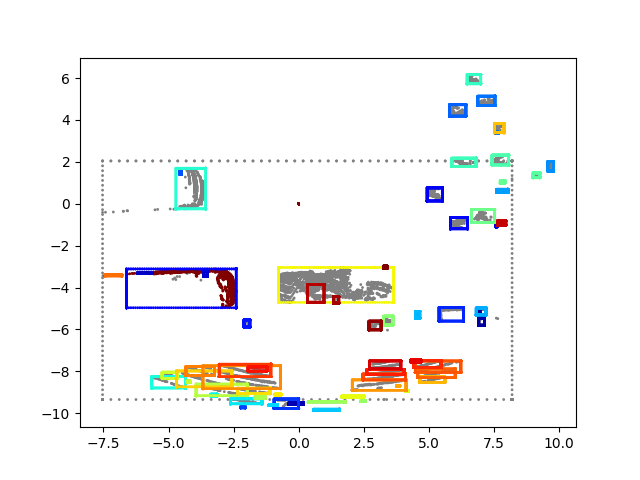

In [8]:
# plt = visualize_boxes_and_masks(pc, boxes, db_clusters)

plt = visualize_boxes_and_masks(pc, boxes, len(boxes) * (inside_mask[:,8]).detach().cpu())
imshow(plt)
# visualize_points3D(pc[0, :, :3].detach().cpu().numpy(), db_clusters.detach().cpu().numpy(), bg_color=(0.5,0.5,0.5,0), show_grid=False, show_axis=False)
# visualize_points3D(pc[0, :, :3].detach().cpu().numpy(), inside_mask[8].detach().cpu().numpy(), bg_color=(0.5,0.5,0.5,0), show_grid=False, show_axis=False)
# visualize_points3D(pc[0, :, :3].detach().cpu().numpy(), inside_mask[:,1:].sum(1).detach().cpu().numpy(), bg_color=(0.5,0.5,0.5,0), show_grid=False, show_axis=False)
visualize_points3D(pc[0, :, :3].detach().cpu().numpy(), logs_mask.argmax(dim=-1)[0].detach().cpu().numpy(), bg_color=(0.5,0.5,0.5,0), show_grid=False, show_axis=False)

In [64]:
for i in tqdm(range(1500)):
    optimizer.zero_grad()
    mask = logs_mask.softmax(dim=-1)
    
    dist, NN, _ = knn_points(pc[:-1, :, :3] + gt_flow[:-1, :, :3], pc[1:, :, :3], lengths1=None, lengths2=None, K=1, return_nn=True)
    
    
    loss = 0
    
    # density-based regularizer
    mean_probs = scatter(logs_mask[:1, db_clusters >=0].softmax(dim=-1), db_clusters[db_clusters >= 0], reduce='sum', dim=1)    # calculate mean mask over clusters
    probs = mean_probs.max(dim=-1)[0] # select the highest probability per instance from masks
    loss += - probs.mean()
    
    # if i > 1000:
    # todo weights on truncated NN distance
    matched_masks = torch.gather(mask[1:], 1, NN[:,:,0].unsqueeze(-1).repeat(1,1,mask.shape[-1]))   # todo unchecked! slightly checked
    continuity_loss = (mask[:-1] - matched_masks).abs()
    
    loss += continuity_loss.mean()
    
    for i in range(len(pc1) - 1):
        smooth_loss, _ = SmoothLosses[i].smoothness_loss(mask[i:i+1], SmoothLosses[i].NN_pc1)
        loss += smooth_loss
        
    loss.mean().backward()  
    optimizer.step()

instances = logs_mask[:-1].argmax(dim=-1).view(-1).cpu().numpy()
visualize_points3D(pc[:-1, :, :3].view(-1,3).detach().cpu().numpy(), instances, bg_color=(0.5,0.5,0.5,0), show_grid=False, show_axis=False)
# visualize_points3D(pc[0, :, :3].view(-1,3).detach().cpu().numpy(), logs_mask[0].argmax(dim=-1), bg_color=(0.5,0.5,0.5,0), show_grid=False, show_axis=False)

100%|██████████| 1500/1500 [00:18<00:00, 82.62it/s]


# Use Temporality for refinement - Shape fitting

In [20]:
# fit one object along time
import torch
from pytorch3d.ops.knn import knn_points
from pytorch3d.transforms import axis_angle_to_matrix
import matplotlib.pyplot as plt
import os

plt.close()
device = torch.device('cuda:0')

# for i in range(len(centers)):
    # centers[i] += i
frames = 3
pts = torch.stack([torch.rand(30, 3) * 1 + torch.tensor((i * 1.5, 3 * torch.tensor(i * 0.3).sin(), i)) for i in range(frames)]).to(device)

centers = torch.stack([pts[i][1] for i in range(len(pts))]).to(device) # random point init

# initialize yaw from initialized centers
x = torch.diff(centers[:,0])# append=torch.diff(centers[-1:,0]))
y = torch.diff(centers[:,1])# append=torch.diff(centers[-1:,1]))
angles = torch.atan2(y, x)
yaw = torch.cat((angles, angles[-1:]), dim=0)[:,None].to(device) # append second last as a approximation of last one
yaw.requires_grad_(True)



# centers = torch.ones((5,3))    
centers.requires_grad_(True)

# next add rotation
optimizer = torch.optim.Adam([centers, yaw], lr=0.01)

    
# batch size = time
# for each cluster, match 1-NN
# gather all combinations? ne, to musi byt zaroven, nektery body proste nemusi mit match

# todo add coverage
# todo freespace in matching the object. Just generate few points in direction to sensor and do not let any point be near it
# todo match only in consecutive times
# normals in registration?
for e in range(85):
    fig, ax = plt.subplots(1,2)
    loss = 0
    
    # calculate 
    rotations = torch.cat((torch.zeros(len(pts),2, device=device), yaw), dim=1)
    rot_mats = axis_angle_to_matrix(rotations)
    rot_mats = rot_mats.permute(0,2,1) # compensate transposition
    transformed_pts = torch.bmm(pts - centers[:, None, :] - centers[:1, None, :], rot_mats) # shift to local object origin center and also put global origin to first center
        
    # Iterate all with all
    for i in range(len(centers)):
        except_mask = torch.arange(len(pts)) != i    
        
        dist, NN, _ = knn_points(transformed_pts[i:i+1], transformed_pts[except_mask].view(1,-1,3), K=1)
        back_dist, NN, _ = knn_points((transformed_pts[except_mask]).view(1,-1,3),transformed_pts[i:i+1], K=1)
        
        # dist, NN, _ = knn_points(pts[i:i+1] - centers[i:i+1] - centers[0], (pts[except_mask] - centers[except_mask, None] - centers[0]).view(1,-1,3), K=1)
        # back_dist, NN, _ = knn_points((pts[except_mask] - centers[except_mask, None] - centers[0]).view(1,-1,3), pts[i:i+1] - centers[i:i+1] - centers[0], K=1)
        loss += dist.mean() + back_dist.mean()
    
    smooth_traj = (torch.diff(centers, dim=0) ** 2).mean() + (torch.diff(rotations, dim=0) ** 2).mean()
    
    loss += smooth_traj
    
    loss.mean().backward()
    optimizer.step()
    optimizer.zero_grad()
        
    for i in range(len(pts)):
        p = pts[i].detach().cpu().numpy()
        ax[0].scatter(p[:,0] - centers[i, 0].detach().cpu().numpy(), p[:,1] - centers[i, 1].detach().cpu().numpy())
        
    for i in range(len(pts)):
        p = pts[i].detach().cpu().numpy()
        ax[1].scatter(p[:,0], p[:,1])
        ax[1].scatter(centers[i, 0].detach().cpu().numpy(), centers[i, 1].detach().cpu().numpy(), c='k', s=100)
        
        
        vis_arrow = torch.stack((centers[i, :2], centers[i, :2]))
        
        vis_arrow[1] += torch.tensor((1, torch.tan(yaw)[i]), device=device)
        ax[1].plot(vis_arrow[:,0].detach().cpu().numpy(), vis_arrow[:,1].detach().cpu().numpy(), 'g-')
        
    ax[0].axis('equal')
    # ax[1].axis('equal')
    ax[1].set_ylim()
    fig.savefig(f'imgs/{e:03d}.png', facecolor='white', transparent=False)
    plt.close()


        
print(centers, yaw)



tensor([[1.0054, 0.6055, 0.8858],
        [2.4110, 1.3488, 1.7384],
        [3.7087, 2.0515, 2.6270]], device='cuda:0', requires_grad=True) tensor([[0.4757],
        [0.4296],
        [0.5612]], device='cuda:0', requires_grad=True)


In [112]:
# calculate 


In [4]:

cluster_mask = (instances == 2)
# times
cluster_pc = pc[:-1].view(-1,4)[cluster_mask]

vis_pc = cluster_pc.reshape(-1,4).detach().cpu().numpy()

# initialize centers and rotations (flow based?)
from torch_scatter import scatter
from pytorch3d.transforms import axis_angle_to_matrix
centers = scatter(cluster_pc[:, :3], cluster_pc[:, 3].long(), dim=0, reduce='mean') # todo later shift for geometrical mean?
rotations = torch.eye(3).repeat(len(centers), 1, 1).to(device)

# linear smoothness
dt = 1
d_xyza = torch.diff(centers, dim=0) / dt
print(d_xyza)

# axis_angle_to_matrix()

# shift to center and rotate for shape fitting, find the rotations and centers that minimize the shape displacements


# visualize_multiple_pcls(*[vis_pc[:,:3], centers.detach().cpu().numpy()])

# visualize_points3D(vis_pc[:,:3], vis_pc[:,3], bg_color=(0.5,0.5,0.5,0), show_grid=False, show_axis=False)
# visualize_flow_and_instances(pc1[0].detach().cpu(), flow=None, mask=mask[0].detach().cpu())
# visualize_flow_and_instances(pc1[1].detach().cpu(), flow=None, mask=mask[1].detach().cpu())
# NN[0,:,0].shape, NN.max(), mask.shape

tensor([[-0.1671, -0.1020,  0.0283],
        [ 0.1031,  0.1766, -0.0059],
        [-0.0566, -0.1881,  0.0102],
        [ 0.0734,  0.1838, -0.0098],
        [-0.0655, -0.1295, -0.0053]], device='cuda:0')


tensor([[ 0.5201,  0.6346,  0.6255],
        [ 0.9994,  0.9990,  0.9990],
        [ 0.5433,  0.6418,  0.5256],
        [-0.3526, -0.3194, -0.4326],
        [-0.9412, -0.9560, -0.9640]], grad_fn=<SinBackward>)

100%|██████████| 100/100 [00:01<00:00, 98.93it/s]


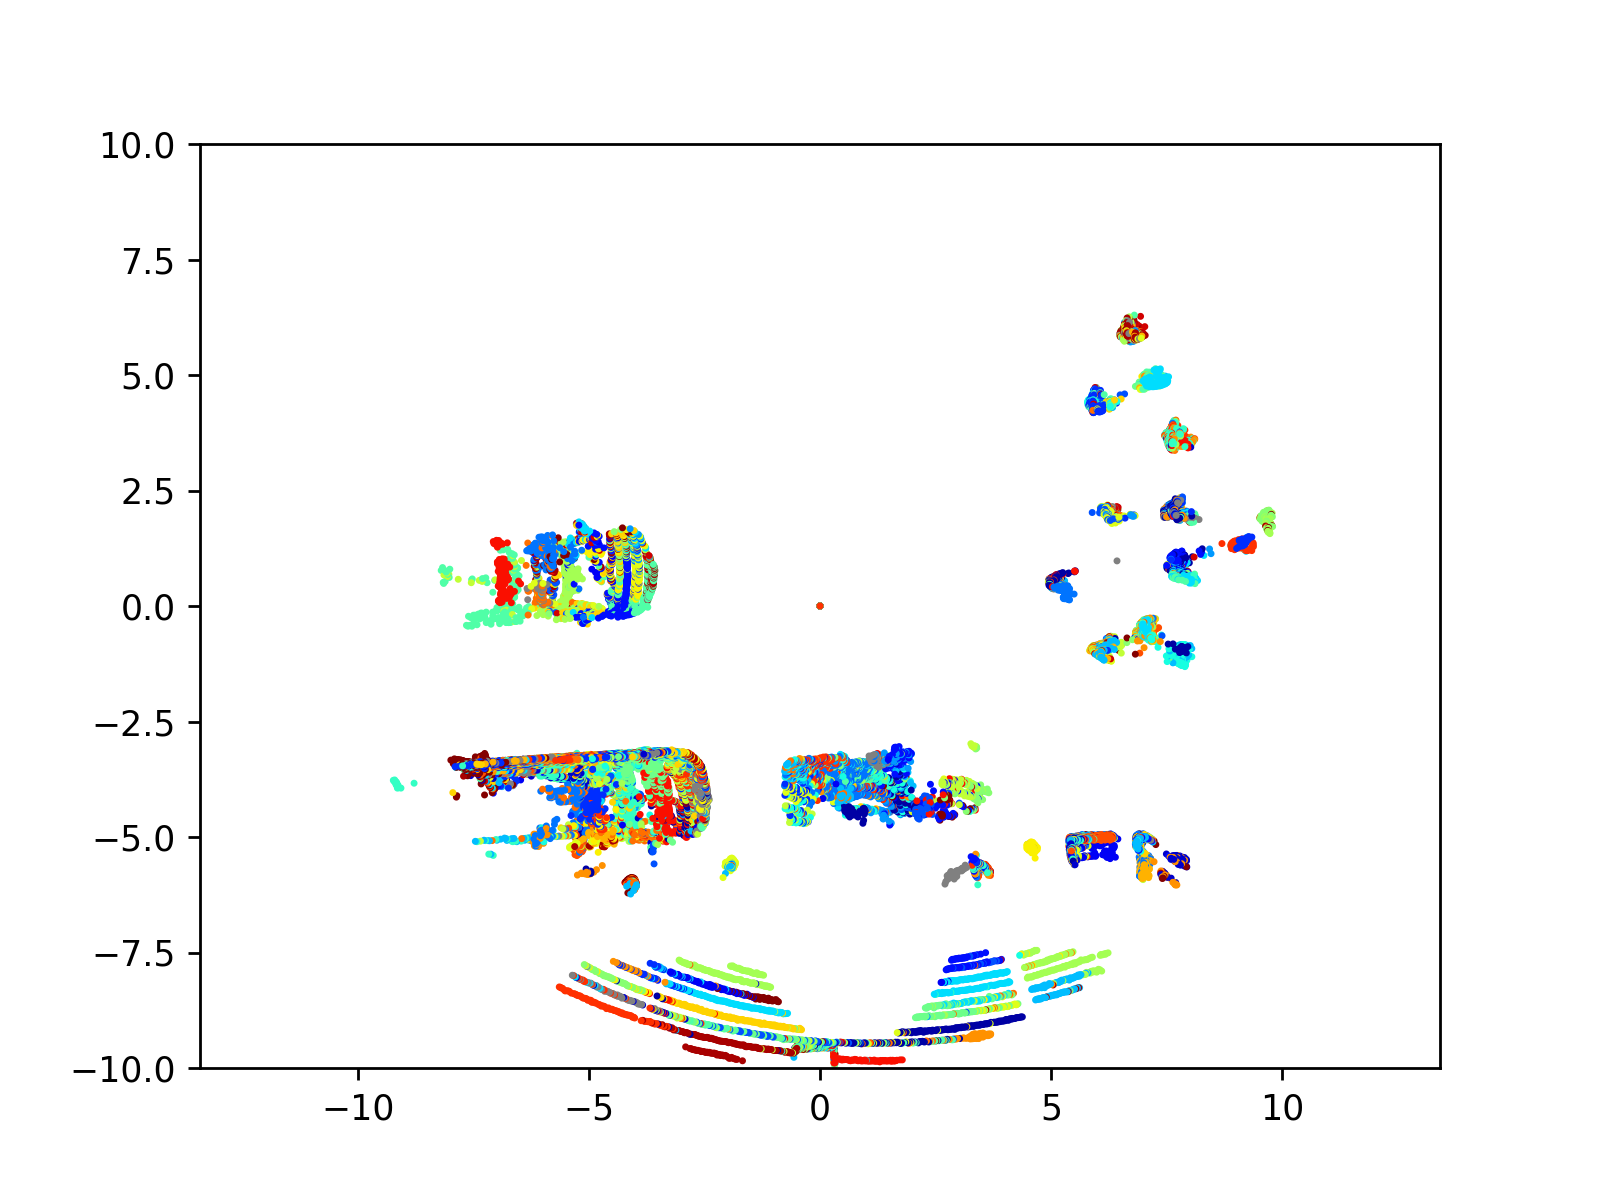

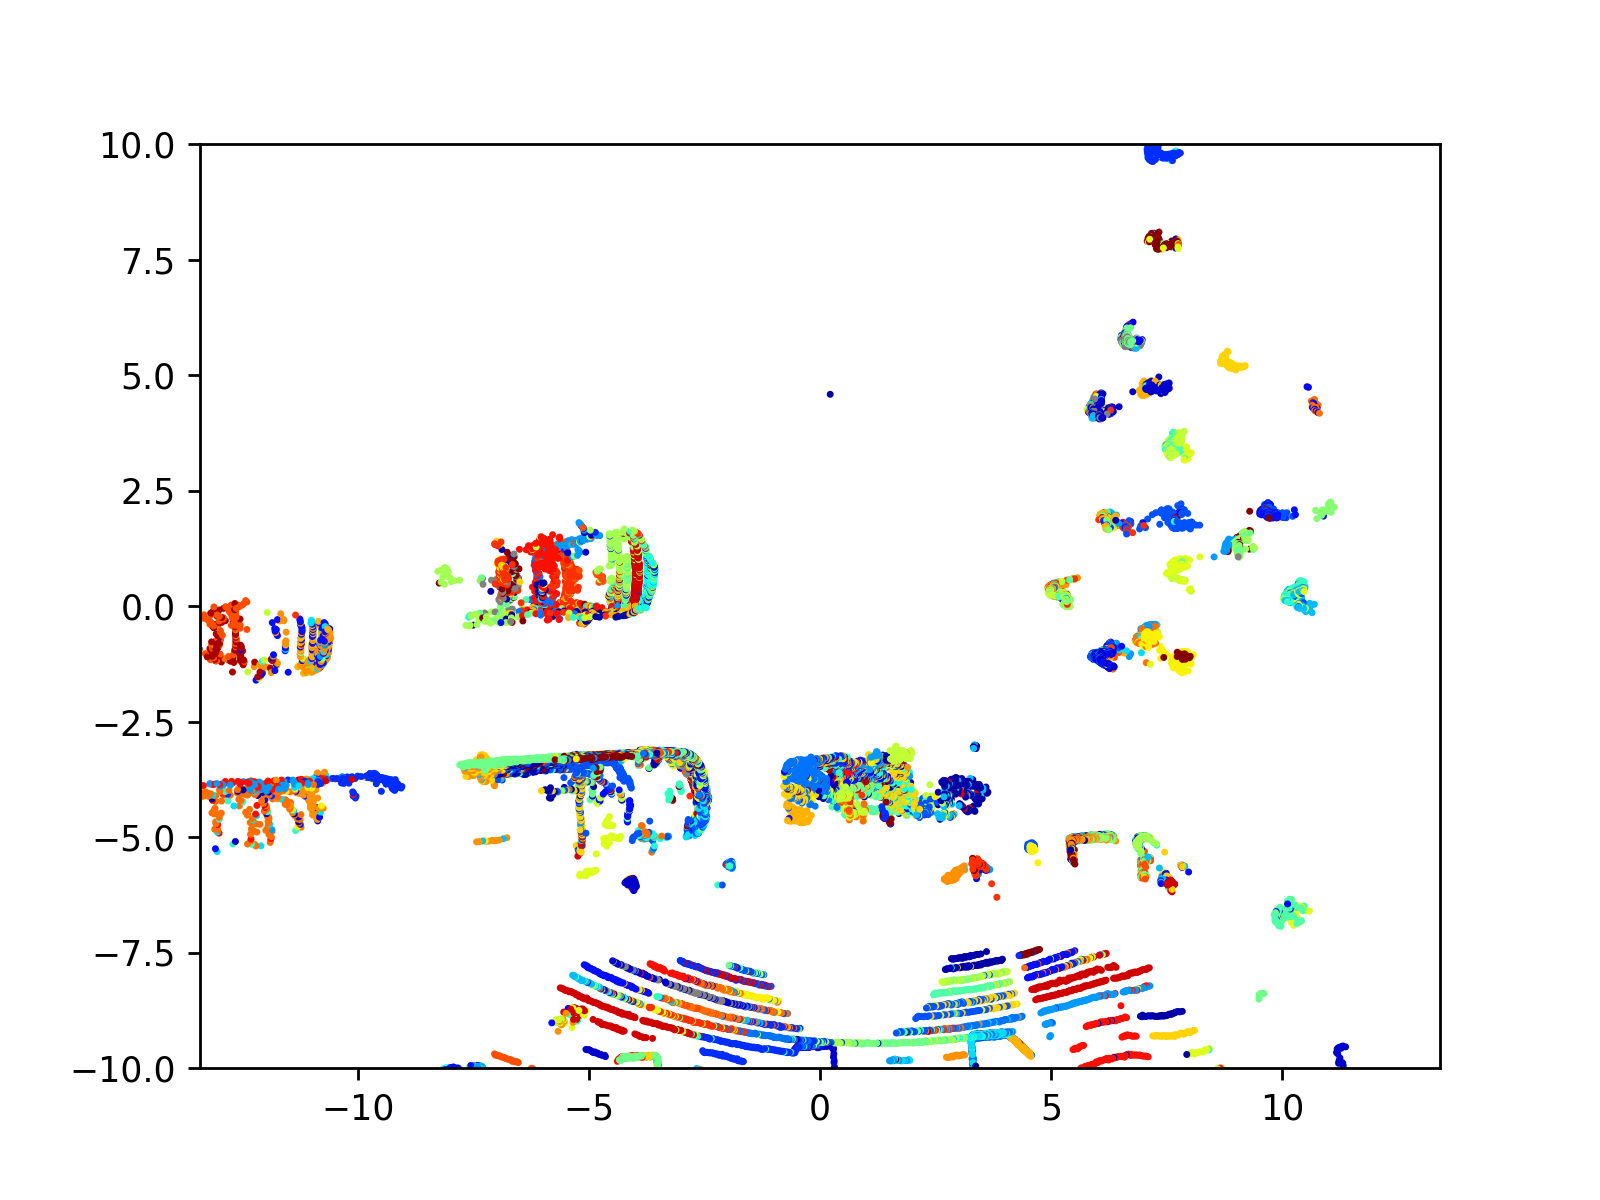

In [6]:

from vis.deprecated_vis import *
from data.dataloader import NSF_dataset
import torch

device = torch.device('cuda:0')
dataset = NSF_dataset(dataset_type='valeo_filip')
# 
first = 1099
max_radius = 70

for file in dataset.all_files[first:first+1]:
    data = np.load(file, allow_pickle=True)

    pc1 = data['pc1']
    pc2 = data['pc2']
    
    pc1_mask = np.linalg.norm(pc1, axis=-1) < max_radius
    pc1 = pc1[pc1_mask]
    pc2 = pc2[np.linalg.norm(pc2, axis=-1) < max_radius]
    pc1 = pc1[pc1[:, 2] > 0.3]  # remove ground
    pc2 = pc2[pc2[:, 2] > 0.3]  # remove ground

pc1 = torch.from_numpy(pc1[None,:]).to(device)
pc2 = torch.from_numpy(pc2[None,:]).to(device)

pose0 = np.load(dataset.all_files[first-1], allow_pickle=True)['pose']
pose1 = data['pose']    

curr_pose = np.linalg.inv(pose1) @ pose0
curr_pose = torch.from_numpy(curr_pose).to(device).to(torch.float32)

shifted_pc1 = pc1[0] @ curr_pose[:3,:3].T + curr_pose[:3,3]

# pc1 = shifted_pc1.unsqueeze(0)
# visualize_multiple_pcls(*[pc1[0].detach().cpu().numpy(), shifted_pc1.detach().cpu().numpy(), pc2[0].detach().cpu().numpy()])


In [7]:
import pandas as pd
from vis.deprecated_vis import *
from tqdm import tqdm
from loss.flow import chamfer_distance_loss, GeneralLoss, FastNN, SC2_KNN
from models.RSNF import NeuralPriorNetwork, RigidMovementPriorNetwork, JointModel

if torch.cuda.is_available():
    device = torch.device(0)
else:
    device = torch.device('cpu')
#

tmp_cfg = {
           'lr': [0.001],
           'K': [16],
           'beta': [0.95],
           'max_radius': [2],
           'grid_factor': [10],
           'smooth_weight': [0],
           'forward_weight': [0],
           'sm_normals_K': [4],
           'init_cluster': [True],
           'early_patience': [100],
           'max_iters': [400],
           'use_normals' : [False],    # 0, 1 - use normals for SC2 KNN search
           'init_transform' : [0],    # 0 - init as eye matrix, 1 - fit transform by NN to pc2 as init
           'use_transform' : [1],     # 0 - do not use trans, 1 - sum rigid and pred flow, 2 - transform is input to model
           'flow_output' : ['flow'],  # flow, rigid
           'SC2' : ['SC2_KNN'],          # MBSC, SC2_KNN
            }

cfg = tmp_cfg
cfg = pd.DataFrame(tmp_cfg).iloc[0].to_dict()
print(cfg)

model = JointModel(pc1, pc2, init_transform=cfg['init_transform'], use_transform=cfg['use_transform'],
                   eps=0, min_samples=0, flow_output=cfg['flow_output']).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=cfg['lr'])

LossModule = GeneralLoss(pc1=pc1, pc2=pc2, dist_mode='DT', K=cfg['K'], max_radius=cfg['max_radius'],
                         smooth_weight=cfg['smooth_weight'],
                         forward_weight=0, sm_normals_K=cfg['sm_normals_K'], pc2_smooth=True)

st = time.time()

SC2_Loss = SC2_KNN(pc1=pc1, K=cfg['K'], use_normals=cfg['use_normals'])

for flow_e in tqdm(range(cfg['max_iters'])):
    pc1 = pc1.contiguous()

    pred_flow = model(pc1)

    loss = LossModule(pc1, pred_flow, pc2)

    loss += cfg['beta'] * SC2_Loss(pred_flow)


    loss.mean().backward()

    optimizer.step()
    optimizer.zero_grad()
    
eval_time = time.time() - st




{'lr': 0.001, 'K': 16, 'beta': 0.95, 'max_radius': 2, 'grid_factor': 10, 'smooth_weight': 0, 'forward_weight': 0, 'sm_normals_K': 4, 'init_cluster': True, 'early_patience': 100, 'max_iters': 400, 'use_normals': False, 'init_transform': 0, 'use_transform': 1, 'flow_output': 'flow', 'SC2': 'SC2_KNN'}


100%|██████████| 400/400 [00:18<00:00, 21.33it/s]


In [15]:
# data['pose']

# todo pridat intuitivni popis na cem je zalozena supervize a jak to souvisi s parametrama
# todo priklad postupu, kdybych to chtel spustit na novych datech (Pandar), jak bych to pouzil
# todo ukaz i na waymo, kde to funguje dobre



compensated_flow = shifted_pc1.unsqueeze(0) - pc1
object_flow = pred_flow - compensated_flow
dynamic_mask = object_flow.norm(dim=-1) > 0.15

visualize_points3D(pc1[0], dynamic_mask[0], bg_color=(1,1,1,0), show_grid=False, show_axis=False)
# visualize_points3D(pc1[0], object_flow[0].norm(dim=-1), bg_color=(1,1,1,0), show_grid=False, show_axis=False)

# visualize_flow3d(pc1[0].detach().cpu().numpy(), pc2[0,:1].detach().cpu().numpy(), object_flow[0].detach().cpu().numpy())
# visualize_flow3d(pc1[0].detach().cpu().numpy(), pc2[0].detach().cpu().numpy(), object_flow[0].detach().cpu().numpy())

In [20]:
from sklearn.cluster import DBSCAN
clusters = DBSCAN(eps=0.5, min_samples=5).fit_predict((pc1+pred_flow)[0].detach().cpu().numpy()) + 1
clusters[dynamic_mask[0].cpu() == 0] = 0

# order instances as integers
for i, idx in enumerate(np.unique(clusters)):
    if idx == 0: continue
    clusters[clusters == idx] = i
    
visualize_points3D(pc1[0].detach().cpu().numpy(), clusters, bg_color=(1,1,1,0), show_grid=False, show_axis=False)

In [36]:
# Kabsch
from ops.transform import find_weighted_rigid_alignment
weights = torch.ones((1,pc1.shape[1])).to(device)

trans = find_weighted_rigid_alignment(pc1, pc1 + pred_flow, weights)[0]

kasbch_shifted_pc1 = (pc1[0] @ trans[:3,:3].T + trans[:3,3]).unsqueeze(0)
# visualize_multiple_pcls(*[pc1[0].detach().cpu().numpy(), kasbch_shifted_pc1[0].detach().cpu().numpy(), pc2[0].detach().cpu().numpy()])
time_label = torch.cat((torch.zeros(pc1.shape[1]), torch.ones(pc2.shape[1]))).to(device)

cat_pc = torch.cat((shifted_pc1.unsqueeze(0), pc2), dim=1)
visualize_points3D(cat_pc[0].detach().cpu().numpy(), time_label.detach().cpu().numpy(), bg_color=(1,1,1,0), show_grid=False, show_axis=False)

